In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import Select
import time
from selenium.webdriver.common.by import By
from itertools import count
import time
from tqdm import tqdm_notebook
import pdb
import re
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import matplotlib.font_manager as fm
from sklearn.preprocessing import OneHotEncoder

In [2]:
best5_df = .l
best5_rookie_df = pd.read_csv('best5_rookie.csv', encoding='cp949')
all_df = pd.read_csv('all_player.csv', encoding='cp949')
rookie_df = pd.read_csv('rookie_player.csv', encoding='cp949')

### **데이터 딕셔너리(Data Dictionary)**

| Variable | Type |
| :-: | :-: |
| player | Categorical |
| position | Categorical |
| 게임수 | Numeric(Continuous) |
| 평균득점 | Numeric(Continuous) |
| 필드골 | Numeric(Continuous) |
| 3점 | Numeric(Continuous) |
| 자유투 | Numeric(Continuous) |
| 리바운드 | Numeric(Continuous) |
| 어시스트 | Numeric(Continuous) |
| 스틸 | Numeric(Continuous) |
| 블록 | Numeric(Continuous) |
| 턴오버 | Numeric(Continuous) |
| 파울 | Numeric(Continuous) |
| 효율성 | Numeric(Continuous) |

In [3]:
filt = all_df["게임수"] == 0
all_df[filt]

all_df.drop(index = [2,15,30,36,46,50,59,66,78,79,85,86,87,109,124,135,140,162], axis = 0, inplace = True)

all_df = all_df.reset_index(drop=True)

In [4]:
all_df.drop(index = [32,40,41,60,93], axis = 0, inplace = True)

all_df = all_df.reset_index(drop=True)

In [5]:
filt = rookie_df["게임수"] == 0
rookie_df[filt]

rookie_df.drop(index = [14,16,21,22,23,32,35,36,42,43,44,45,47,48], axis = 0, inplace = True)

rookie_df = rookie_df.reset_index(drop=True)

In [6]:
target = all_df['게임수']
target.describe()

count    155.000000
mean     191.006452
std      166.187365
min        1.000000
25%       43.000000
50%      163.000000
75%      309.000000
max      678.000000
Name: 게임수, dtype: float64

C:\Users\Yun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


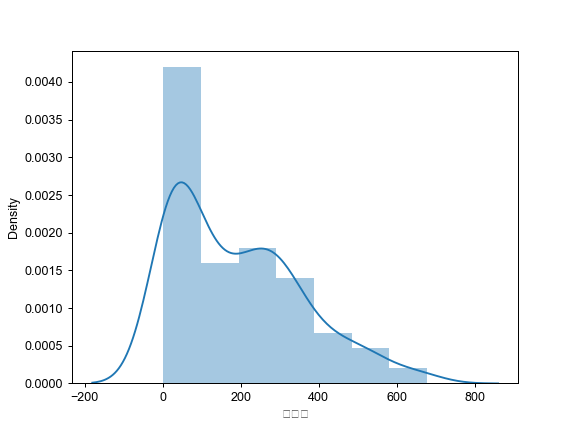

<AxesSubplot:xlabel='게임수', ylabel='Density'>

In [7]:
sns.distplot(all_df['게임수'])

In [8]:
# 왜도
skew = target.skew()
# 첨도
kurt = target.kurtosis()
print('Value - 왜도: {0}, 첨도: {1}'.format(skew, kurt))

Value - 왜도: 0.7844543928386527, 첨도: -0.11529656026265966


In [9]:
category_feature = [ col for col in all_df.columns if all_df[col].dtypes == "object"]
numerical_features = list(set(all_df.columns) - set(category_feature) - set(['게임수']))
numerical_features = np.sort(numerical_features)
print(numerical_features)
print(category_feature)

['3점' '리바운드' '블록' '스틸' '어시스트' '자유투' '턴오버' '파울' '평균득점' '필드골' '효율성']
['player']


In [10]:
for i in numerical_features:
    r, pval = stats.pearsonr(all_df[f'{i}'], all_df.게임수)
    print(i,'r:', round(r, 2),'p-value:',round(pval,4))

3점 r: 0.44 p-value: 0.0
리바운드 r: 0.49 p-value: 0.0
블록 r: 0.27 p-value: 0.0008
스틸 r: 0.62 p-value: 0.0
어시스트 r: 0.54 p-value: 0.0
자유투 r: 0.54 p-value: 0.0
턴오버 r: 0.54 p-value: 0.0
파울 r: 0.47 p-value: 0.0
평균득점 r: 0.6 p-value: 0.0
필드골 r: 0.49 p-value: 0.0
효율성 r: 0.61 p-value: 0.0


In [11]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

C:\Users\Yun\AppData\Local\Temp\ipykernel_21400\495279268.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<IPython.core.display.Javascript object>


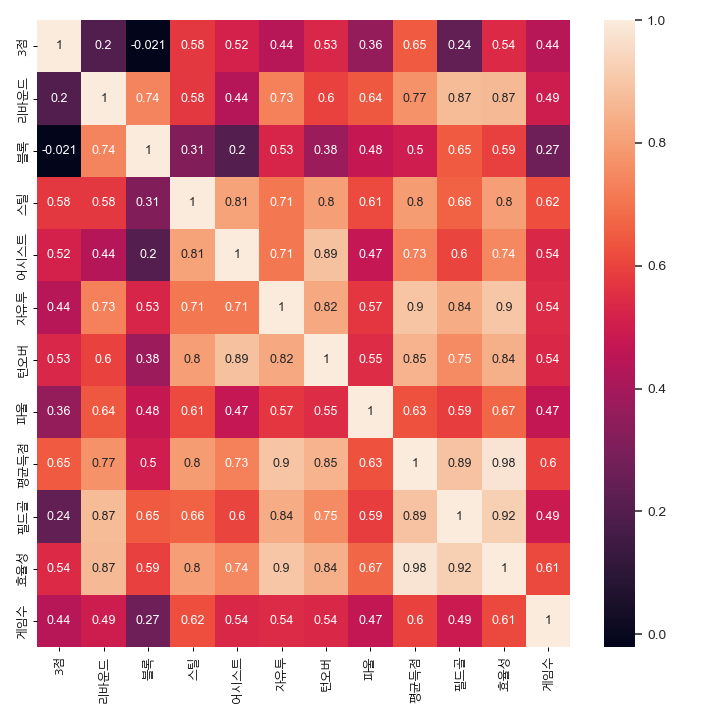

In [12]:
font_list = [font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'NanumGothic'

corr_features = ['3점', '리바운드', '블록', '스틸', '어시스트', '자유투', '턴오버', '파울', '평균득점', '필드골', '효율성', '게임수']
cols = corr_features
corr = all_df[cols].corr(method = 'pearson') 

fig = plt.figure(figsize=(8,8))
ax = fig.gca()  

sns.set(font_scale=1) 
hm = sns.heatmap(corr.values,
                 annot=True, 
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols,
                 ax=ax)
plt.tight_layout()
plt.show()

In [14]:
future_game=[]
for i in range(len(rookie_df['player'])):
    future_game.append(0.27*all_df['3점'][i]
                      +0.46*all_df['리바운드'][i]+0.28*all_df['블록'][i]
                      +0.48*all_df['스틸'][i]+0.35*all_df['어시스트'][i]
                      +0.5*all_df['자유투'][i]-0.47*all_df['턴오버'][i]
                      -0.37*all_df['파울'][i]+0.47*all_df['평균득점'][i]
                      +0.43*all_df['필드골'][i]+0.49*all_df['효율성'][i])
    
rookie_df['future_game']=future_game

<IPython.core.display.Javascript object>


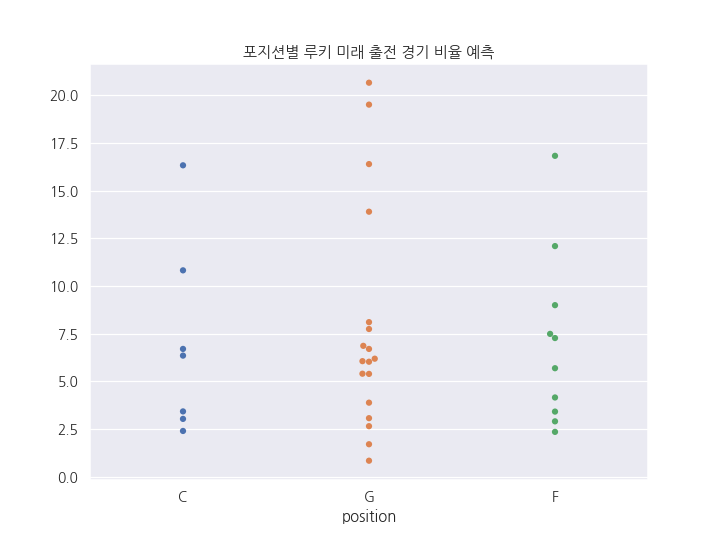

Text(0.5, 1.0, '포지션별 루키 미래 출전 경기 비율 예측')

In [15]:
main_color = "#16a085"
strong_main_color = "#ffeb3b"
custom_colors = [strong_main_color, main_color]

font_list = [font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'NanumGothic'

FG_rookie = rookie_df['future_game'].to_list()
float_FG_rookie = []
for item in FG_rookie:
    float_FG_rookie.append(float(item))
    
plt.figure(figsize=(8,6))
FG_rookie_plot = sns.swarmplot(x=rookie_df["position"],
                                y=float_FG_rookie)
FG_rookie_plot.set_title("포지션별 루키 미래 출전 경기 비율 예측")

In [17]:
Cs = rookie_df[rookie_df['position']=='C']
Gs = rookie_df[rookie_df['position']=='G']
Fs = rookie_df[rookie_df['position']=='F']

C=Cs.sort_values(by='future_game', ascending=False)
G=Gs.sort_values(by='future_game', ascending=False)
F=Fs.sort_values(by='future_game', ascending=False)

future_C = C.drop(['position', 'future_game', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수'], 
                  axis=1).rename(columns={'player':'centers'}).reset_index(drop=True)

future_G = G.drop(['position', 'future_game', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수'], 
                  axis=1).rename(columns={'player':'guards'}).reset_index(drop=True)

future_F = F.drop(['position', 'future_game', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수'], 
                  axis=1).rename(columns={'player':'forwards'}).reset_index(drop=True)

future = pd.concat([future_C, future_G, future_F], axis=1)
future.head()

,centers,guards,forwards
0,하윤기,김동준,주현우
1,선상혁,이우석,신승민
2,서정현,윤원상,이근휘
3,김영현,윤성준,임현택
4,이원석,김준환,문시윤


In [18]:
_C=Cs.sort_values(by='게임수', ascending=False)
_G=Gs.sort_values(by='게임수', ascending=False)
_F=Fs.sort_values(by='게임수', ascending=False)

C_future = _C.drop(['position', 'future_game', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수'], 
                  axis=1).rename(columns={'player':'centers'}).reset_index(drop=True)

G_future = _G.drop(['position', 'future_game', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수'], 
                  axis=1).rename(columns={'player':'guards'}).reset_index(drop=True)

F_future = _F.drop(['position', 'future_game', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수'], 
                  axis=1).rename(columns={'player':'forwards'}).reset_index(drop=True)

future = pd.concat([C_future, G_future, F_future], axis=1)
future.head()

,centers,guards,forwards
0,김영현,오재현,한승희
1,이원석,이우석,신승민
2,하윤기,박지원,차민석
3,박진철,이준희,신민석
4,조우성,이정현,이근휘


In [19]:
future_game_all=[]
for i in range(len(all_df['player'])):
    future_game_all.append(0.27*all_df['3점'][i]
                      +0.46*all_df['리바운드'][i]+0.28*all_df['블록'][i]
                      +0.48*all_df['스틸'][i]+0.35*all_df['어시스트'][i]
                      +0.5*all_df['자유투'][i]-0.47*all_df['턴오버'][i]
                      -0.37*all_df['파울'][i]+0.47*all_df['평균득점'][i]
                      +0.43*all_df['필드골'][i]+0.49*all_df['효율성'][i])
    
all_df['future_game']=future_game_all

In [20]:
player_level = []
play_game = all_df['게임수'].to_list()
play_game = list(map(int, play_game))
for i in range(len(play_game)):
    if play_game[i]>=200:
        player_level.append('main')
    else:
        player_level.append('sub')
        
all_df['player_level'] = player_level

<IPython.core.display.Javascript object>


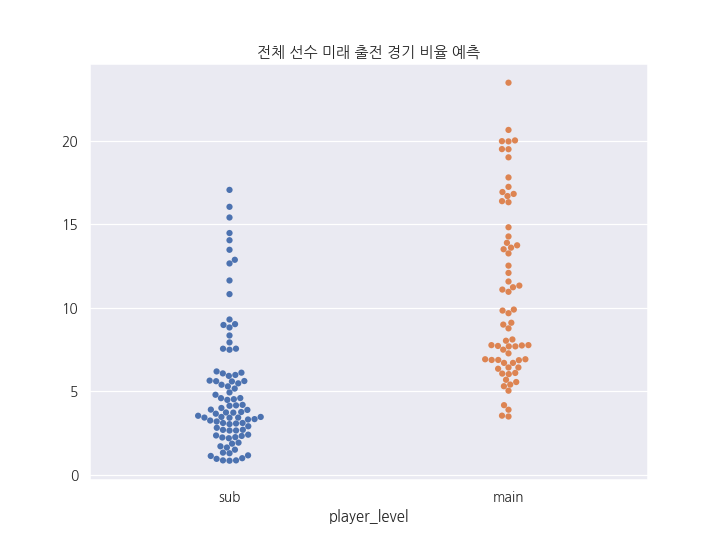

Text(0.5, 1.0, '전체 선수 미래 출전 경기 비율 예측')

In [21]:
main_color = "#16a085"
strong_main_color = "#ffeb3b"
custom_colors = [strong_main_color, main_color]

font_list = [font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'NanumGothic'

FG_all = all_df['future_game'].to_list()
float_FG_all = []
for item in FG_all:
    float_FG_all.append(float(item))
    
plt.figure(figsize=(8,6))
FG_all_plot = sns.swarmplot(x=all_df['player_level'],
                            y=float_FG_all)
FG_all_plot.set_title("전체 선수 미래 출전 경기 비율 예측")

In [22]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(all_df[["player_level"]])
one_hot_encoded = ohe.transform(all_df[["player_level"]])
ohe_df = pd.DataFrame(one_hot_encoded, columns = ohe.categories_[0])
df_one = pd.concat([all_df, ohe_df], axis = 1)
df_one.drop(columns = ["player_level"], axis = 1, inplace = True)

target = all_df['future_game']
var_list=['main','sub']

for i in var_list:
    point = stats.pointbiserialr(df_one[i], target)
    print( i, '와 예상 경기수 상관분석\n', point)

main 와 예상 경기수 상관분석
 PointbiserialrResult(correlation=0.5352559196067338, pvalue=7.215935881792667e-13)
sub 와 예상 경기수 상관분석
 PointbiserialrResult(correlation=-0.5352559196067338, pvalue=7.215935881792667e-13)


In [23]:
list_best5 = best5_df['player'].to_list()
best5_position = best5_df['position'].to_list()

In [24]:
section_index=[]
for x in list_best5:
    index=all_df[all_df['player']==x].index[0]
    section_index.append(index)
set_index = set(section_index)
list_index = list(set_index)
position=[]
best5=[]
for i in range(len(all_df['player'])):
    best5.append(0)
    position.append('None')
    
for j in range(len(list_index)):
    best5[section_index[j]]=1
    position[section_index[j]]=best5_position[j]

all_df['best5']=best5
all_df['position']=position

In [25]:
Cs = all_df[all_df['position']=='센터']
Gs = all_df[all_df['position']=='가드']
Fs = all_df[all_df['position']=='포워드']

In [26]:
Cs_con = pd.concat([Cs,all_df])
Gs_con = pd.concat([Gs,all_df])
Fs_con = pd.concat([Fs,all_df])

In [27]:
all_df.drop(index=list_index, axis=0, inplace=True)

In [29]:
columns_list=['3점', '리바운드', '블록', '스틸', '어시스트', '자유투', 
           '턴오버', '파울', '평균득점', '필드골', '효율성', '게임수']

for i in columns_list:
    point = stats.pointbiserialr(Gs_con[i], Gs_con['best5'])
    print('가드 포지션에서 ', i, '와 best선수 선발여부 상관분석\n', point)

가드 포지션에서  3점 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.4449352131343864, pvalue=3.3512651213575464e-09)
가드 포지션에서  리바운드 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.4329887705631096, pvalue=9.65872902653249e-09)
가드 포지션에서  블록 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.24504597221452298, pvalue=0.0017304963163456595)
가드 포지션에서  스틸 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5503259632430508, pvalue=3.9622385134579234e-14)
가드 포지션에서  어시스트 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5923691026158995, pvalue=1.264218032288442e-16)
가드 포지션에서  자유투 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.6268201840224606, pvalue=5.865822748409971e-19)
가드 포지션에서  턴오버 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5915678324020334, pvalue=1.4217176416687767e-16)
가드 포지션에서  파울 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.2305514749459568, pvalue=0.00325763090482288)
가드 포지션에서  평균득점 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlati

In [30]:
for i in columns_list:
    point = stats.pointbiserialr(Cs_con[i], Cs_con['best5'])
    print('센터 포지션에서 ', i, '와 best선수 선발여부 상관분석\n', point)

센터 포지션에서  3점 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.2927971107983487, pvalue=0.00019819004627919838)
센터 포지션에서  리바운드 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5269165142167841, pvalue=1.3513606316696477e-12)
센터 포지션에서  블록 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.36918974418495787, pvalue=1.953686443391737e-06)
센터 포지션에서  스틸 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.444154741171376, pvalue=5.648293928162486e-09)
센터 포지션에서  어시스트 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.48242683589460544, pvalue=1.5746775305590142e-10)
센터 포지션에서  자유투 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.6026770600173406, pvalue=6.768071198793471e-17)
센터 포지션에서  턴오버 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5150036845240689, pvalue=5.172467635633972e-12)
센터 포지션에서  파울 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.23317747335598535, pvalue=0.0032929270450819817)
센터 포지션에서  평균득점 와 best선수 선발여부 상관분석
 PointbiserialrResult(corre

In [31]:
for i in columns_list:
    point = stats.pointbiserialr(Fs_con[i], Fs_con['best5'])
    print('포워드 포지션에서 ', i, '와 best선수 선발여부 상관분석\n', point)

포워드 포지션에서  3점 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.3944414309412586, pvalue=2.4560371143633557e-07)
포워드 포지션에서  리바운드 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5377094804956271, pvalue=2.2713905646232262e-13)
포워드 포지션에서  블록 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.3675742324356703, pvalue=1.7399303826718127e-06)
포워드 포지션에서  스틸 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.45837919576197705, pvalue=1.0932667847283753e-09)
포워드 포지션에서  어시스트 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5056365024755284, pvalue=9.121497782266128e-12)
포워드 포지션에서  자유투 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.6042545706747379, pvalue=2.6825705061720372e-17)
포워드 포지션에서  턴오버 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.5183749578945952, pvalue=2.2036340395543546e-12)
포워드 포지션에서  파울 와 best선수 선발여부 상관분석
 PointbiserialrResult(correlation=0.21552329763552736, pvalue=0.006199370747736744)
포워드 포지션에서  평균득점 와 best선수 선발여부 상관분석
 PointbiserialrR

In [33]:
rookie_C = rookie_df[rookie_df['position']=='C']
rookie_G = rookie_df[rookie_df['position']=='G']
rookie_F = rookie_df[rookie_df['position']=='F']
rookie_C = rookie_C.reset_index(drop=True)
rookie_G = rookie_G.reset_index(drop=True)
rookie_F = rookie_F.reset_index(drop=True)

In [34]:
play_well_value_C=[]
for i in range(len(rookie_C['player'])):
    play_well_value_C.append(0.25*rookie_C['3점'][i]+0.24*rookie_C['스틸'][i]
                             +0.24*rookie_C['어시스트'][i]+0.28*rookie_C['게임수'][i]
                             +0.23*rookie_C['평균득점'][i]+0.21*rookie_C['효율성'][i])

rookie_C['play_well_value']=play_well_value_C

In [35]:
play_well_value_G=[]
for i in range(len(rookie_G['player'])):
    play_well_value_G.append(0.45*rookie_G['리바운드'][i]
                           +0.39*rookie_G['블록'][i]+0.27*rookie_G['스틸'][i]
                           +0.27*rookie_G['어시스트'][i]+0.48*rookie_G['자유투'][i]
                           -0.35*rookie_G['턴오버'][i]+0.43*rookie_G['평균득점'][i]
                           +0.49*rookie_G['필드골'][i]+0.45*rookie_G['효율성'][i])
    
rookie_G['play_well_value']=play_well_value_G

In [36]:
play_well_value_F=[]
for i in range(len(rookie_F['player'])):
    play_well_value_F.append(0.25*rookie_F['3점'][i]+0.27*rookie_F['리바운드'][i]
                           +0.29*rookie_F['스틸'][i]+0.31*rookie_F['어시스트'][i]
                           +0.40*rookie_F['자유투'][i]-0.37*rookie_F['턴오버'][i]
                           +0.39*rookie_F['평균득점'][i]+0.36*rookie_F['필드골'][i]
                           +0.37*rookie_F['효율성'][i]+0.23*rookie_F['게임수'][i])
    
rookie_F['play_well_value']=play_well_value_F

In [40]:
best5_position=best5_df['position'].to_list()
best5_rookie_df['position']=best5_position

In [41]:
best_C = best5_rookie_df[best5_rookie_df['position']=='센터']
best_G = best5_rookie_df[best5_rookie_df['position']=='가드']
best_F = best5_rookie_df[best5_rookie_df['position']=='포워드']
best_C = best_C.reset_index(drop=True)
best_G = best_G.reset_index(drop=True)
best_F = best_F.reset_index(drop=True)

In [42]:
play_well_value_C=[]
for i in range(len(best_C['player'])):
    play_well_value_C.append(0.25*best_C['3점'][i]+0.24*best_C['스틸'][i]
                             +0.24*best_C['어시스트'][i]+0.28*best_C['게임수'][i]
                             +0.23*best_C['평균득점'][i]+0.21*best_C['효율성'][i])

best_C['play_well_value']=play_well_value_C

play_well_value_G=[]
for i in range(len(best_G['player'])):
    play_well_value_G.append(0.45*best_G['리바운드'][i]
                           +0.39*best_G['블록'][i]+0.27*best_G['스틸'][i]
                           +0.27*best_G['어시스트'][i]+0.48*best_G['자유투'][i]
                           -0.35*best_G['턴오버'][i]+0.43*best_G['평균득점'][i]
                           +0.49*best_G['필드골'][i]+0.45*best_G['효율성'][i])
    
best_G['play_well_value']=play_well_value_G

play_well_value_F=[]
for i in range(len(best_F['player'])):
    play_well_value_F.append(0.25*best_F['3점'][i]+0.27*best_F['리바운드'][i]
                           +0.29*best_F['스틸'][i]+0.31*best_F['어시스트'][i]
                           +0.40*best_F['자유투'][i]-0.37*best_F['턴오버'][i]
                           +0.39*best_F['평균득점'][i]+0.36*best_F['필드골'][i]
                           +0.37*best_F['효율성'][i]+0.23*best_F['게임수'][i])

best_F['play_well_value']=play_well_value_F

In [44]:
print('season_best 센터의 루키시즌 play_well_value : ', best_C['play_well_value'].mean())
print('season_best 가드의 루키시즌 play_well_value : ',best_G['play_well_value'].mean())
print('season_best 포워드의 루키시즌 play_well_value : ',best_F['play_well_value'].mean())

season_best 센터의 루키시즌 play_well_value :  19.859666666047502
season_best 가드의 루키시즌 play_well_value :  14.292500000912833
season_best 포워드의 루키시즌 play_well_value :  24.122933332084


In [45]:
C_mean = best_C['play_well_value'].mean()
G_mean = best_G['play_well_value'].mean()
F_mean = best_F['play_well_value'].mean()
C_confidence_interval = (best_C['play_well_value'].std()/best_C['play_well_value'].count())*1.96
G_confidence_interval = (best_G['play_well_value'].std()/best_G['play_well_value'].count())*1.96
F_confidence_interval = (best_F['play_well_value'].std()/best_F['play_well_value'].count())*1.96

In [46]:
print('시즌 베스트 선수(센터)들의 루키시즌 play_well_value의 평균 신뢰구간 : \n(',
      C_mean-C_confidence_interval, ',', C_mean+C_confidence_interval, ')\n')

print('시즌 베스트 선수(가드)들의 루키시즌 play_well_value의 평균 신뢰구간 : \n(',
      G_mean-G_confidence_interval, ',', G_mean+G_confidence_interval, ')\n')

print('시즌 베스트 선수(포워드)들의 루키시즌 play_well_value의 평균 신뢰구간 : \n(',
      F_mean-F_confidence_interval, ',', F_mean+F_confidence_interval, ')')

시즌 베스트 선수(센터)들의 루키시즌 play_well_value의 평균 신뢰구간 : 
( 19.13528762161034 , 20.584045710484666 )

시즌 베스트 선수(가드)들의 루키시즌 play_well_value의 평균 신뢰구간 : 
( 13.22438020027879 , 15.360619801546877 )

시즌 베스트 선수(포워드)들의 루키시즌 play_well_value의 평균 신뢰구간 : 
( 21.986047900410355 , 26.259818763757643 )


In [48]:
rookie_all = pd.concat([rookie_C, rookie_F, rookie_G])

<IPython.core.display.Javascript object>


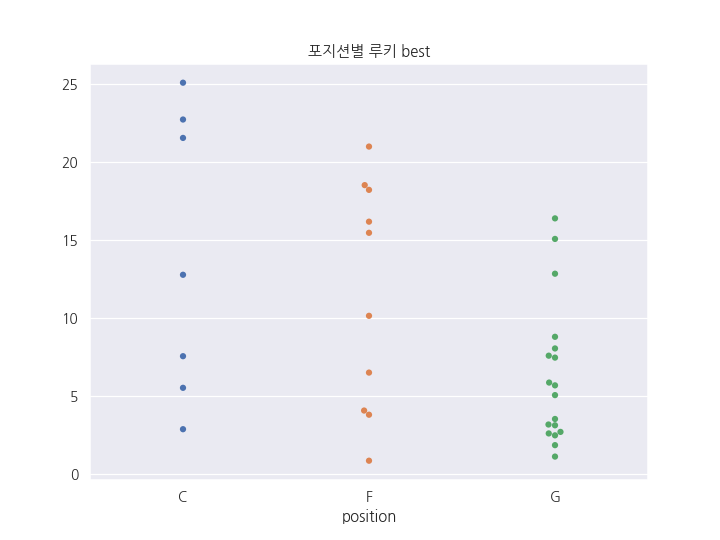

Text(0.5, 1.0, '포지션별 루키 best')

In [49]:
font_list = [font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'NanumGothic'

main_color = "#16a085"
strong_main_color = "#ffeb3b"
custom_colors = [strong_main_color, main_color]

rookie_ = rookie_all['play_well_value'].to_list()
rookie_pwv = []
for item in rookie_:
    rookie_pwv.append(float(item))
    
plt.figure(figsize=(8,6))
pwv_rookie_plot = sns.swarmplot(x=rookie_all["position"],
                                y=rookie_pwv)

pwv_rookie_plot.set_title("포지션별 루키 best")

In [52]:
Cs = rookie_all[rookie_all['position']=='C']
Gs = rookie_all[rookie_all['position']=='G']
Fs = rookie_all[rookie_all['position']=='F']

C=Cs.sort_values(by='play_well_value', ascending=False)
G=Gs.sort_values(by='play_well_value', ascending=False)
F=Fs.sort_values(by='play_well_value', ascending=False)

future_C = C.drop(['position', 'play_well_value', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수',
                   'future_game'], 
                  axis=1).rename(columns={'player':'centers'}).reset_index(drop=True)

future_G = G.drop(['position', 'play_well_value', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수', 
                   'future_game'], 
                  axis=1).rename(columns={'player':'guards'}).reset_index(drop=True)

future_F = F.drop(['position', 'play_well_value', '3점', '리바운드', 
                   '블록', '스틸', '어시스트', '자유투', '턴오버', 
                   '파울', '평균득점', '필드골', '효율성', '게임수', 
                   'future_game'], 
                  axis=1).rename(columns={'player':'forwards'}).reset_index(drop=True)

future = pd.concat([future_C, future_G, future_F], axis=1)
future.head()

,centers,guards,forwards
0,김영현,이우석,한승희
1,이원석,이정현,신승민
2,하윤기,이승우,차민석
3,박진철,정호영,신민석
4,조우성,박지원,이근휘


In [53]:
well_C = C[C['play_well_value']>=19.135]
well_G = G[G['play_well_value']>=13.224]
well_F = F[F['play_well_value']>=21.986]
well_play_list_1 = []

well_play_list_1.append(well_C['player'].to_list())
well_play_list_1.append(well_G['player'].to_list())
well_play_list_1.append(well_F['player'].to_list())
well_play_list = sum(well_play_list_1, [])

print('시즌 best를 수상한 선수들의 루키시즌 기대값을 뛰어넘은 선수 : \n', well_play_list)


시즌 best를 수상한 선수들의 루키시즌 기대값을 뛰어넘은 선수 : 
 ['김영현', '이원석', '하윤기', '이우석', '이정현']
